# Gameplan

To get different particle numbers at the same couplings, I will increment different solutions simultaneously! Woah that's crazy.

In [12]:
from solve_rg_eqs import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


l = 16
L = 2*l
print('Ns:')
Ns = np.arange(2, l+4, 2)
print(Ns)
k = np.arange(1, 2*l+1, 2)*0.5*np.pi/l
Gc = 1./np.sum(k)
dg = 0.01/L
g0 = .1*dg
imk = .1*g0
imv = .1*g0

Gf = .2*Gc

gs = np.arange(g0, G_to_g(.2*Gc, k), dg)
qs = np.arange(1/gs[-1], 1/G_to_g(1.2*Gc, k), -10*dg)
print(len(gs))
print(len(qs))

Ns:
[ 2  4  6  8 10 12 14 16 18]
32
34267


In [2]:
def bootstrap_g0_multi(L, g0, kc, imscale_v, final_N=None):
    vs = np.zeros(L)

    Ns = np.arange(2, 4*L, 2)
    if final_N is not None:
        Ns = np.arange(2, final_N+2, 2)
    Ne = Ns[-1]//2
    sols = [None for N in Ns]
    for i, N in enumerate(Ns):
        log('')
        log('Now using {} fermions'.format(N))
        log('')
        n = N//2
        dims = (L, n, n)
        print('Dimensions')
        print(dims)
        # Solving for 2n fermions using extrapolation from previous solution
        if n <= 2:
            force_gs=False
            noise_factors=None
            vars = g0_guess(L, n, n, kc, g0, imscale=imscale_v)
        else:
            # The previous solution matches to roughly the accuracy of the solution
            # for the shared variables
            noise_factors = 10*er*np.ones(len(vars))
            # But we will still need to try random stuff for the 4 new variables
            noise_factors[n-2:n] = 1
            noise_factors[2*n-2:2*n] = 1
            noise_factors[3*n-2:3*n] = 1
            noise_factors[4*n-2:4*n] = 1
        sol = find_root_multithread(vars, kc, g0, dims, imscale_v,
                                    max_steps=MAX_STEPS_1,
                                    use_k_guess=False,
                                    noise_factors=noise_factors,
                                    force_gs=force_gs,
                                    factor=1.4)
        print(vars)
        vars = sol.x
        er = max(abs(rgEqs(vars, kc, g0, dims)))
        log('Error with {} fermions: {}'.format(2*n, er))
        sols[i] = sol
        
        if n%2 == 1:
            # setting up for N divisible by 4 next step
            if n > 1:
                vars = sols[i-1].x # Better to start from last similar case
            n -= 1
            incr = 2
        else:
            incr = 1
        
        if n >= 1:
            es, ws = unpack_vars(vars, n, n)
            vars_guess = g0_guess(L, n+incr, n+incr, kc, g0, imscale=imscale_v)
            esg, wsg = unpack_vars(vars_guess, n+incr, n+incr)
            es = np.append(es, esg[-incr:])
            ws = np.append(ws, wsg[-incr:])
            vars = pack_vars(es, ws)        

    return sols, Ns


def solve_job(prev_vars, kc, g, dims, prev_g):
    sol = root(rgEqs, prev_vars, args=(kc, g, dims), method='lm',
               jac=rg_jac)
    er = np.max(np.abs(sol.fun))
    if er > 10**-6:
        gts = np.linspace(prev_g, g, 10)
        for gt in gts:
            sol = root(rgEqs, prev_vars, args=(kc, gt, dims), method='lm',
                       jac=rg_jac)
            prev_vars = sol.x
    return sol


def solve_g_all(l, Ns, g, kc, prev_g, prev_sols):
    dims = [(l, N//2, N//2) for N in Ns]
    with concurrent.futures.ProcessPoolExecutor(max_workers=CPUS) as executor:
        future_results = [executor.submit(solve_job, ps.x, kc, g, dims[Ni], prev_g) for Ni, ps in enumerate(prev_sols)]
        concurrent.futures.wait(future_results)
        for res in future_results:
            try:
                yield res.result()
            except Exception as e:
                print(e)

In [3]:
kim = imk*(-1)**np.arange(1,l+1)
print(kim)
kc = np.concatenate((k, kim))
skip = 10

final_N = l+2
Ns = np.arange(2, final_N+2, 2)
print(Ns)
prev_sols = [None for N in Ns]
energies = np.zeros((len(gs//skip), len(Ns)))
ers = np.zeros((len(gs//skip), len(Ns)))
# varss = []
# gss = []
for gi, g in enumerate(gs):
    print('')
    if g == gs[0]:
        prev_sols, Ns = bootstrap_g0_multi(l, g, kc, imscale_v=imv, final_N=final_N)
    else:
        print('g = {}'.format(g))
        g_prev = gs[gi-1]
        for i, s in enumerate(solve_g_all(l, Ns, g, kc, g_prev, prev_sols)):
            prev_sols[i] = s
    for Ni, ps in enumerate(prev_sols):
        N = Ns[Ni]
        print('Error for N = {}'.format(N))
        print(np.max(np.abs(ps.fun)))

[-1.25e-05  1.25e-05 -1.25e-05  1.25e-05]
[ 2  4  6  8 10 12 14]


Now using 2 fermions

Dimensions
(4, 1, 1)
[ 3.92679805e-01 -1.16243864e-05  0.00000000e+00  0.00000000e+00]
Error with 2 fermions: 8.988081390270964e-13

Now using 4 fermions

Dimensions
(4, 2, 2)
Bad initial guess. Trying with noise.
g = 0.000125, er = 0.00019203384406864645
1th try at g = 0.000125
Smallest error from last set: 0.00019203384406864645
Noise ranges from -1.6542610574215633e-05 to 1.7334906762214004e-05
[ 3.92679805e-01  3.92679805e-01 -1.16243864e-05 -1.33743864e-05
  3.92692656e-01  3.92692656e-01 -5.24997955e-05  2.75002045e-05]
Error with 4 fermions: 3.4062850318150595e-12

Now using 6 fermions

Dimensions
(4, 3, 3)
[ 3.92686859e-01  3.92653469e-01  1.17792376e+00 -1.24992218e-05
 -1.24970960e-05  1.42481592e-05  3.92670164e-01  3.92670163e-01
  0.00000000e+00 -2.85943992e-06 -2.21368777e-05  0.00000000e+00]
Error with 6 fermions: 1.5354544302681461e-12

Now using 8 fermions

Dimensions
(4, 4, 4)
Bad

Error for N = 2
3.645084234449313e-15
Error for N = 4
2.1870505406695883e-14
Error for N = 6
9.568346115429449e-15
Error for N = 8
1.7921664152709125e-14
Error for N = 10
1.1542766742422826e-14
Error for N = 12
1.1912970609984085e-14
Error for N = 14
1.731415011363424e-14

g = 0.022624999999999996
Error for N = 2
3.2152058793144526e-15
Error for N = 4
1.0683562038442632e-14
Error for N = 6
1.4042891302180739e-14
Error for N = 8
7.83204057164255e-15
Error for N = 10
6.430411758628905e-15
Error for N = 12
9.806377931909081e-15
Error for N = 14
1.7201351454332323e-14

g = 0.023874999999999997
Error for N = 2
2.3749890942781344e-15
Error for N = 4
2.1544543926665936e-14
Error for N = 6
1.085709300241433e-14
Error for N = 8
7.920164524222173e-15
Error for N = 10
1.7133849894435113e-14
Error for N = 12
9.765022124241794e-15
Error for N = 14
1.866062859789963e-14

g = 0.025124999999999995
Error for N = 2
2.677857935395877e-15
Error for N = 4
1.9994672584289213e-14
Error for N = 6
8.5691453932

In [4]:
final_energies = np.zeros(len(Ns))
for Ni, N in enumerate(Ns):
    print('Removing imaginary parts at N = {}'.format(N))
    dims = (l, N//2, N//2)
    vars_r, er_r = increment_im_k(prev_sols[Ni].x, dims, g, k, kc[l:], force_gs=False, steps=50, max_steps=5)
    varss = np.transpose(np.array([vars_r]))
    energy, _ = calculate_energies(dims, [g], k, varss)
    final_energies[Ni] = energy[0]

Removing imaginary parts at N = 2
s = 1.0
s = 0.976
s = 0.9471999999999999
s = 0.9126399999999999
s = 0.8711679999999999
s = 0.8214016
s = 0.76168192
s = 0.690018304
s = 0.6040219648
s = 0.5180256256
s = 0.4320292864
s = 0.3460329472
s = 0.260036608
s = 0.1740402688
s = 0.08804392960000001
s = 0.002047590400000021
Calculating R_k, energy
Removing imaginary parts at N = 4
s = 1.0
s = 0.976
s = 0.9471999999999999
s = 0.9126399999999999
s = 0.8711679999999999
s = 0.8214016
s = 0.76168192
s = 0.690018304
s = 0.6040219648
s = 0.5180256256
s = 0.4320292864
s = 0.3460329472
s = 0.260036608
s = 0.1740402688
s = 0.08804392960000001
s = 0.002047590400000021
Calculating R_k, energy
Removing imaginary parts at N = 6
s = 1.0
s = 0.976
s = 0.9471999999999999
s = 0.9126399999999999
s = 0.8711679999999999
s = 0.8214016
s = 0.76168192
s = 0.690018304
s = 0.6040219648
s = 0.5180256256
s = 0.4320292864
s = 0.3460329472
s = 0.260036608
s = 0.1740402688
s = 0.08804392960000001
s = 0.002047590400000021
Calc

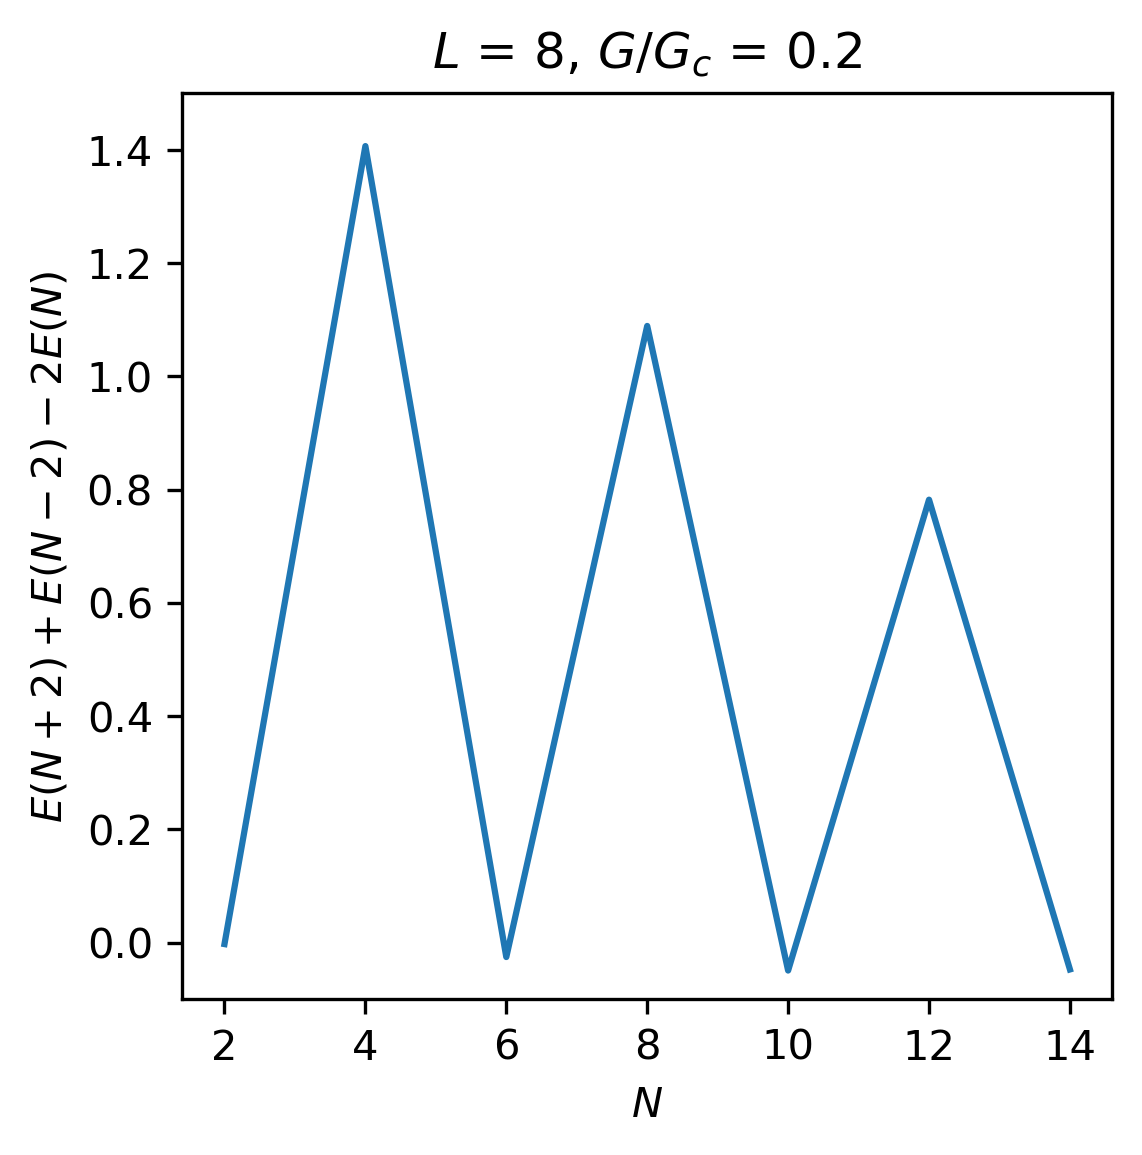

In [8]:
# plt.plot(Ns, final_energies)
plt.figure(figsize=(4,4), dpi=300)
gaps = np.zeros(len(Ns))
G = g_to_G(gs[-1], k)
for Ni, N in enumerate(Ns):
    if Ni == 0:
        em1 = -3*G*np.sum(k**2)
    else:
        em1 = final_energies[Ni-1]
    if N == 4*l:
        ep1 = 4*np.sum(k)-3*G*np.sum(k**2)-4*G*(np.sum(k))**2
    else:
        ep1 = final_energies[Ni+1]
    gaps[Ni] = (ep1+em1 - 2*final_energies[Ni])
plt.plot(Ns, gaps)
plt.ylim(-0.1, 1.5)
plt.xlabel('$N$')
plt.ylabel('$E(N+2)+E(N-2)-2E(N)$')
plt.title('$L$ = {}, $G/G_c$ = {}'.format(L, 0.2))
plt.savefig('quad_gaps_low_g_L_{}.png'.format(L))

(32,)
(32, 7)


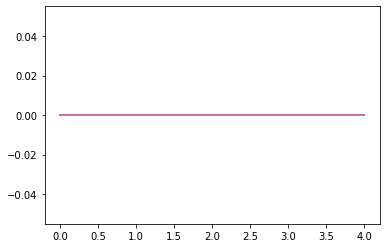

In [6]:
print(np.shape(gs))
print(np.shape(ers))
Gs = g_to_G(gs, k)
for Ni, N in enumerate(Ns):
    if np.max(ers[:, Ni]) < 10**-6:
        plt.plot(energies[:5, Ni])